<a href="https://colab.research.google.com/github/rpavlik/image-proc-nn-testing/blob/master/point_location_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import IPython.display as display
import numpy as np

from tensorflow.keras import datasets, layers, models


TensorFlow 2.x selected.


In [0]:
BUFFER_SIZE = 50
BATCH_SIZE = 20
IMG_WIDTH = 512
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

Clone repo with data in it

In [3]:
!git clone https://github.com/rpavlik/image-proc-nn-testing.git

Cloning into 'image-proc-nn-testing'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (514/514), done.
remote: Total 518 (delta 9), reused 509 (delta 3), pack-reused 0
Receiving objects: 100% (518/518), 66.20 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [4]:
!(cd image-proc-nn-testing && git pull)

Already up to date.


Make a dataset with all the filenames in it, showing a few of them as a sample.

In [5]:
list_ds = tf.data.Dataset.list_files('image-proc-nn-testing/set1/*.png')
for f in list_ds.take(5):
  print(f.numpy())


b'image-proc-nn-testing/set1/img_172_116.png'
b'image-proc-nn-testing/set1/img_333_254.png'
b'image-proc-nn-testing/set1/img_7_173.png'
b'image-proc-nn-testing/set1/img_75_86.png'
b'image-proc-nn-testing/set1/img_212_169.png'


In [0]:
def decode_img(img):
  img = tf.image.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  return img

def process_path(file_path):

  parts = tf.strings.split(file_path, '/')
  fn_parts = tf.strings.split(tf.strings.split(parts[-1], '.')[0], '_')
  
  return tf.io.read_file(file_path), tf.strings.to_number(fn_parts[1:])



In [7]:
labeled_ds = list_ds.map(process_path)

for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text)


b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\xed\xeb\xf3\xca\x00\x00\x004IDATx\x9c\xed\xcc\xa1\r\x00\x00\x08\xc00\xc2\x1d\xfc\x7f'\x16\x0f\x86\xa4US\x8b\x00\x008P\xa3s;[\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80g\x1aV\x17\x00!qx0\xd8\x00\x00\x00"

tf.Tensor([420.  33.], shape=(2,), dtype=float32)


In [0]:
def handle_image(img, label):
  return decode_img(img), label


In [9]:

decoded_labeled_ds = labeled_ds.map(handle_image)

for image, label in decoded_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 512, 1)
Label:  [22.  7.]


the following is from https://www.tensorflow.org/tutorials/load_data/images#basic_methods_for_training

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(tf.image.grayscale_to_rgb(tf.convert_to_tensor(image_batch[n])))
      plt.title(str(label_batch[n]))
      plt.axis('off')


In [0]:
train_ds = prepare_for_training(decoded_labeled_ds)

it = iter(train_ds)
image_batch, label_batch = next(it)
test_image_batch, test_label_batch = next(it)


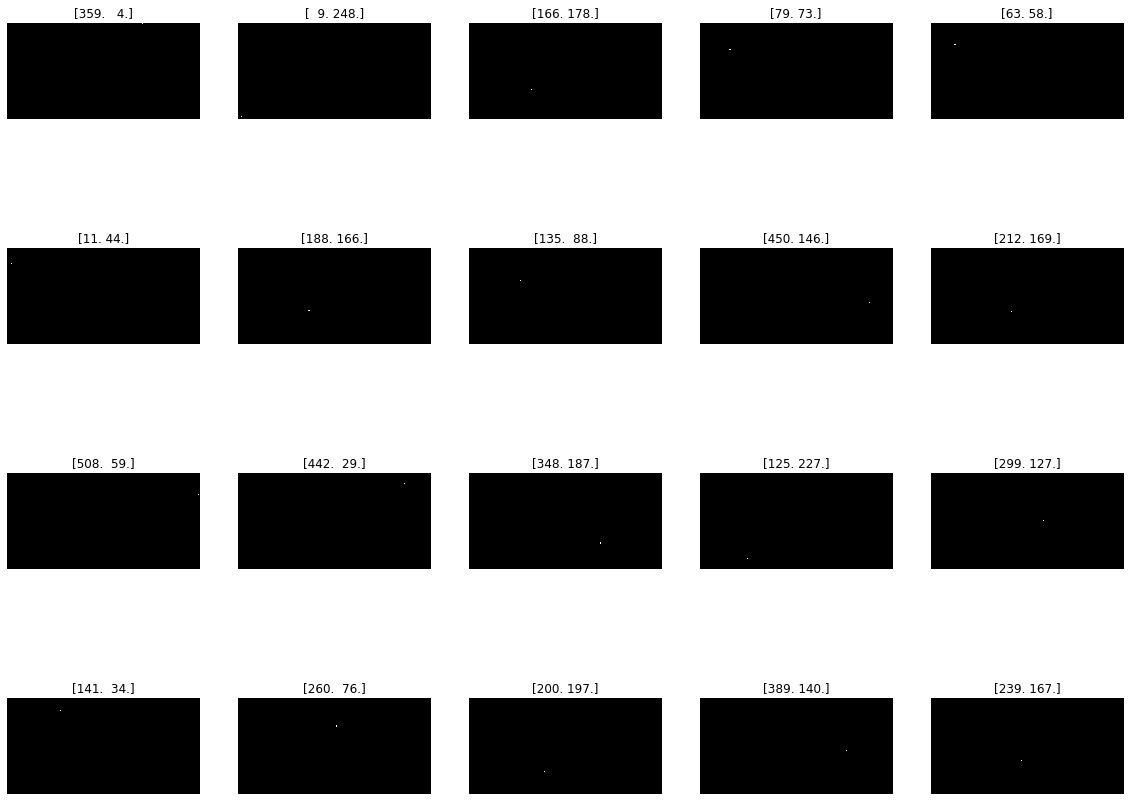

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())


make sure we have our dims right

In [0]:
for image in image_batch:
  assert(image.get_shape() == (IMG_HEIGHT, IMG_WIDTH, 1))

start creating our model - turns out a conv layer was not only not needed, it made it slower and less accurate.



In [0]:
model = models.Sequential()
#model.add(layers.Conv2D(2, 33, activation='relu', ))
#model.add(layers.Conv2D(10, 65, activation='relu'))
model.add(layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(layers.Dense(10, activation='relu'))

# Last layer has 2 nodes for output: one for x, one for y
model.add(layers.Dense(2))

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              #optimizer='adam',
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1310730   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 1,310,752
Trainable params: 1,310,752
Non-trainable params: 0
_________________________________________________________________


Now, before we train, let's look at the model and try using it to predict, with just whatever init data is in there.

The fact this shows two floats for each image means the data types are at least right.

In [0]:
model.predict(image_batch)

array([[-0.00929022,  0.01601044],
       [ 0.0080074 , -0.01431593],
       [ 0.00180589, -0.00317474],
       [ 0.01195329, -0.00012057],
       [ 0.01639706, -0.00076416],
       [ 0.0030568 ,  0.00185436],
       [ 0.01336938, -0.00176203],
       [ 0.00641984, -0.00673306],
       [ 0.00326903, -0.00091997],
       [ 0.00385871, -0.0006345 ],
       [ 0.00126437, -0.00595214],
       [-0.00630476, -0.00273106],
       [ 0.00301865,  0.00394113],
       [-0.00152681,  0.00071691],
       [ 0.01639829, -0.01194369],
       [ 0.01758792, -0.00880824],
       [ 0.00522034,  0.00175111],
       [ 0.00120066,  0.00478298],
       [ 0.00999195, -0.01397665],
       [ 0.02172948, -0.00333879]], dtype=float32)

In [0]:
#history = model.fit(image_batch, label_batch, epochs=20, validation_data=(test_image_batch, test_label_batch))
history = model.fit(train_ds, steps_per_epoch=400, validation_data=prepare_for_training(decoded_labeled_ds), validation_steps=10, epochs=20)

Train for 400 steps, validate for 10 steps
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 16419.5407 - mae: 93.9252 - mse: 16419.5391 - val_loss: 13935.5762 - val_mae: 88.0870 - val_mse: 13935.5771
Epoch 2/20
400/400 [==============================] - 5s 11ms/step - loss: 12225.3401 - mae: 83.4781 - mse: 12225.3408 - val_loss: 9369.8122 - val_mae: 73.9525 - val_mse: 9369.8135
Epoch 3/20
400/400 [==============================] - 5s 11ms/step - loss: 9026.1458 - mae: 74.5824 - mse: 9026.1465 - val_loss: 7117.4795 - val_mae: 67.1592 - val_mse: 7117.4795
Epoch 4/20
400/400 [==============================] - 5s 11ms/step - loss: 6921.7351 - mae: 67.3083 - mse: 6921.7363 - val_loss: 6172.5313 - val_mae: 63.8273 - val_mse: 6172.5312
Epoch 5/20
400/400 [==============================] - 4s 11ms/step - loss: 5659.2277 - mae: 61.0597 - mse: 5659.2266 - val_loss: 4914.3205 - val_mae: 56.4867 - val_mse: 4914.3203
Epoch 6/20
400/400 [==============================] - 5s

based on https://www.tensorflow.org/tutorials/images/cnn#evaluate_the_model

Hey, it appears to be working!

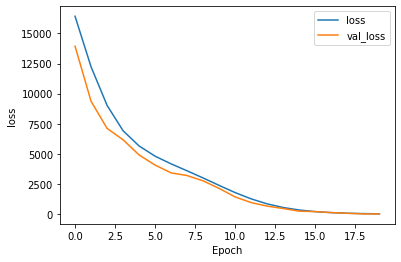

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

#test_loss, test_acc = model.evaluate(test_image_batch, test_label_batch, verbose=2)


In [0]:
model.predict(image_batch)

array([[218.24423 , 235.853   ],
       [443.6995  ,  61.76374 ],
       [460.7654  , 120.54729 ],
       [446.672   , 123.72502 ],
       [151.53331 ,  71.91726 ],
       [395.9789  , 203.29413 ],
       [321.29593 , 115.77761 ],
       [ 60.306503, 101.30931 ],
       [195.61497 , 206.68724 ],
       [330.444   , 149.94925 ],
       [382.41995 , 161.34511 ],
       [373.59863 ,  80.89171 ],
       [138.43472 , 119.837395],
       [505.71356 ,  76.571144],
       [482.57385 ,  96.022   ],
       [259.0262  , 246.81448 ],
       [157.37274 ,  10.770681],
       [161.49106 ,  80.86551 ],
       [  9.272263, 109.40018 ],
       [134.34587 , 168.00577 ]], dtype=float32)

In [0]:
label_batch

<tf.Tensor: id=285, shape=(20, 2), dtype=float32, numpy=
array([[219., 236.],
       [444.,  62.],
       [460., 121.],
       [446., 124.],
       [152.,  72.],
       [396., 203.],
       [322., 116.],
       [ 60., 101.],
       [196., 207.],
       [331., 150.],
       [382., 161.],
       [374.,  81.],
       [139., 120.],
       [506.,  77.],
       [482.,  96.],
       [260., 247.],
       [158.,  11.],
       [162.,  81.],
       [ 16., 109.],
       [134., 168.]], dtype=float32)>